# Applying Machine Learning on UrbanSound8k 

## Install Packages

We install: 
- Machine learning libraries: `tensorflow`, `sklearn`
- Audio processing: `librosa`
- Plots: `Plotly`, `matplotlib`

In [9]:
!pip install pandas
!pip install setuptools
!pip install numpy
!pip install sklearn
!pip install librosa
!pip install plotly
!pip install matplotlib
!pip install pillow
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 2.1 MB/s eta 0:00:00m eta 0:00:010:00:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 4.2 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━

In [1]:
# Unzip dataset
import os

if not os.path.isdir("UrbanSound8K"):
    !wget https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz -O urban8k.tgz
    !tar -xzf urban8k.tgz
    !rm urban8k.tgz


In [2]:
import time
import librosa
import zipfile
import numpy as np
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from PIL import Image

import tensorflow as tf
print("TensorFlow version:", tf.__version__)

2022-04-15 21:54:11.343152: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-15 21:54:11.343225: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


TensorFlow version: 2.8.0


## Design Choices and Models

Проанализировав набор данных и потратив немного времени на чтение о современном состоянии классификации аудиосигналов, я сделал следующие варианты дизайна и предложения:

Обучите свёрточную нейронную сеть и используйте в качестве входных данных MFCC, STFT или Mel-Spectogram.

- Поскольку продолжительность аудио варьируется от 0 до 4 с, я дополняю сгенерированную спектрограмму, чтобы сделать все аудио равной длины.

Варианты признаков:

Использование MFCC в качестве признаков:
   - Обычно вычисляют первые 13 MFCC, их производные и вторые производные и используют их в качестве признаков.
   - Или также обычно используется 40 MFCC, так как это значение по умолчанию для Librosa.

- Использование STFT в качестве признаков:
   - Содержит меньше человеческой обработки, чем MFCC и Mel-Spectogram, CNN может изучать другие фильтры, а не представления, разработанные людьми.

- Использование Mel-Spectogram в качестве признаков:
   - Преобразование, примененное к STFT, которое приблизительно соответствует тому, как люди воспринимают звук. Немного проще чем MFCC, но немного сложнее чем STFT.

Моим первым выбором было бы использование STFT и Mel-Spectogram, поскольку похоже, что CNN могут использовать больше преимуществ частотно-временной структуры, но из-за **вычислительных ресурсов** и ограниченного времени я покажу использование **MFCC** в качестве функций. поскольку они намного более эффективны с точки зрения памяти.
 

## Dataset Preprocessing and Splits

Я загружаю все аудиоданные с помощью Librosa и частоты дискретизации по умолчанию 22050 Гц. Это дизайнерское решение основано на
([Источник](https://librosa.org/blog/2019/07/17/resample-on-load/#Okay...-but-why-22050-Hz?--Why-not-44100-or-48000?)) и в дальнейших экспериментах можно было попробовать разные частоты дискретизации.

> Люди могут слышать примерно до 20000 Гц, можно успешно анализировать музыкальные и речевые данные на гораздо более низких частотах без особых потерь. Самые высокие частоты, которые мы обычно стараемся обнаружить, составляют около C9 ≈ 8372 Гц, что значительно ниже порога 11025, подразумеваемого fs = 22050.

По умолчанию Librosa загружает звук в моно, давая нам 1 канал.



In [8]:
# FeatureExtractor class including librosa audio processing functions
class FeatureExtractor:
    def __init__(self, csv_file):
        self.csv_file = csv_file
        self.max_audio_duration = 4
        self.dataset_df = self._create_dataset(csv_file)
    
    @staticmethod
    def _create_dataset(csv_file):
        """
        Args:
            dataset_path: path with the .wav files after unzipping
        Returns: A pandas dataframe with the list of files and labels (`filenames`, `labels`)
        """
        dataset_df = pd.read_csv(csv_file)
        filepaths = []
        for i, row in dataset_df.iterrows():
            filepaths.append(os.path.join('UrbanSound8K/audio', 'fold'+str(row['fold']), row['slice_file_name']))
        dataset_df['filepath'] = filepaths
        return dataset_df

    @staticmethod
    def _compute_max_pad_length(max_audio_length, sample_rate=22050, n_fft=2048, hop_length=512):
        dummy_file = np.random.random(max_audio_length*sample_rate)
        stft = librosa.stft(dummy_file, n_fft=n_fft, hop_length=hop_length)
        # Return an even number for CNN computation purposes
        if stft.shape[1] % 2 != 0:
            return stft.shape[1] + 1
        return stft.shape[1]

    def compute_save_features(self, 
                        mode='mfcc', 
                        sample_rate=22050,
                        n_fft=2048,
                        hop_length=512,
                        n_mfcc=40,
                        output_path='features',
                        deltas=False
                        ):
        dataset_features = []
        max_pad = self._compute_max_pad_length(self.max_audio_duration, 
                                               sample_rate=sample_rate, 
                                               n_fft=n_fft,
                                               hop_length=hop_length)
        print('Max Padding = ', max_pad)
        
        if not os.path.exists(output_path):
            print('Creating output folder: ', output_path)
            os.makedirs(output_path)
        else:
            print('Output folder already existed')
            
        print('Saving features in ', output_path)
        i = 0
        t = time.time()
        
        features_path = []
        for filepath in self.dataset_df['filepath']:
            if i % 100 == 0:
                print('{} files processed in {}s'.format(i, time.time() - t))
            audio_file, sample_rate = librosa.load(filepath, sr=sample_rate, res_type='kaiser_fast')
            if mode == 'mfcc':
                audio_features = self.compute_mfcc(audio_file, sample_rate, n_fft, hop_length, n_mfcc, deltas)  
            elif mode == 'stft':
                audio_features = self.compute_stft(audio_file, sample_rate, n_fft, hop_length)
            elif mode == 'mel-spectogram':
                audio_features = self.compute_mel_spectogram(audio_file, sample_rate, n_fft, hop_length)
            
            audio_features = np.pad(audio_features, 
                                    pad_width=((0, 0), (0, max_pad - audio_features.shape[1])))
            
            save_path = os.path.join(output_path, filepath.split('/')[-1].replace('wav', 'npy'))
            self.save_features(audio_features, save_path)
            features_path.append(save_path)
            i+=1
        self.dataset_df['features_path'] = features_path
        return self.dataset_df
    
    @staticmethod
    def save_features(audio_features, filepath):
        np.save(filepath, audio_features)

    @staticmethod
    def compute_mel_spectogram(audio_file, sample_rate, n_fft, hop_length):
        return librosa.feature.melspectrogram(audio_file,
                                              sr=sample_rate, 
                                              n_fft=n_fft,
                                              hop_length=hop_length)
    @staticmethod
    def compute_stft(audio_file, sample_rate, n_fft, hop_length):
        return librosa.stft(audio_file, n_fft=n_fft, hop_length=hop_length)
    
    @staticmethod
    def compute_mfcc(audio_file, sample_rate, n_fft, hop_length, n_mfcc, deltas=False):
        mfccs = librosa.feature.mfcc(audio_file,
                                    sr=sample_rate, 
                                    n_fft=n_fft,
                                    n_mfcc=n_mfcc,
                                    )
        # Change mode from interpolation to nearest
        if deltas:
          delta_mfccs = librosa.feature.delta(mfccs, mode='nearest')
          delta2_mfccs = librosa.feature.delta(mfccs, order=2, mode='nearest')
          return np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
        return mfccs

In [9]:
# Create dataset and extract features
fe = FeatureExtractor('UrbanSound8K/metadata/UrbanSound8K.csv')

In [ ]:
#run to compute and save features on the colab notebook
if not os.path.isdir("features_mfcc"):
    dataset_df = fe.compute_save_features(mode='mfcc', n_mfcc=13, output_path='features_mfcc', deltas=True)

Доступ к диску и librosa загрузка аудиофайлов очень медленная на ноутбуке colab (30-40 минут), вместо этого мы могли бы загрузить предварительно вычисленные функции.

In [10]:
# Unzip features
if not os.path.isdir("features_mfcc"):
    !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1BU2B5EcbfyGBIOkB5YC44hpzPpuqw43H' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1BU2B5EcbfyGBIOkB5YC44hpzPpuqw43H" -O features_mfcc.zip && rm -rf /tmp/cookies.txt
    !unzip -q features_mfcc.zip
    !rm features_mfcc.zip

--2022-04-11 11:11:31--  https://docs.google.com/uc?export=download&confirm=t&id=1BU2B5EcbfyGBIOkB5YC44hpzPpuqw43H
Загружен сертификат CA «/etc/ssl/certs/ca-certificates.crt»
Распознаётся docs.google.com (docs.google.com)… 216.58.212.142, 2a00:1450:4001:801::200e
Подключение к docs.google.com (docs.google.com)|216.58.212.142|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 303 See Other
Адрес: https://doc-00-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/99aubrtq2opaqimj8e121587tst6dog7/1649664675000/12555612686504083087/*/1BU2B5EcbfyGBIOkB5YC44hpzPpuqw43H?e=download [переход]
Предупреждение: в HTTP маски не поддерживаются.
--2022-04-11 11:11:31--  https://doc-00-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/99aubrtq2opaqimj8e121587tst6dog7/1649664675000/12555612686504083087/*/1BU2B5EcbfyGBIOkB5YC44hpzPpuqw43H?e=download
Распознаётся doc-00-1k-docs.googleusercontent.com (doc-00-1k-docs.googleusercontent

In [3]:
# Download dataset.json file
if not os.path.isfile("dataset.json"):
    !wget --no-check-certificate "https://docs.google.com/uc?export=download&id=1pzSvGYaBXghLQFTZxlSex-Ts3T4B0X4C" -O dataset.json
    dataset_df = pd.read_json('dataset.json')

--2022-04-15 21:58:07--  https://docs.google.com/uc?export=download&id=1pzSvGYaBXghLQFTZxlSex-Ts3T4B0X4C
Загружен сертификат CA «/etc/ssl/certs/ca-certificates.crt»
Распознаётся docs.google.com (docs.google.com)… 142.250.186.142, 2a00:1450:4001:82a::200e
Подключение к docs.google.com (docs.google.com)|142.250.186.142|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 303 See Other
Адрес: https://doc-0s-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qi5tg9ogpab3qpg9p2fksefire97vus7/1650049050000/12555612686504083087/*/1pzSvGYaBXghLQFTZxlSex-Ts3T4B0X4C?e=download [переход]
Предупреждение: в HTTP маски не поддерживаются.
--2022-04-15 21:58:09--  https://doc-0s-1k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qi5tg9ogpab3qpg9p2fksefire97vus7/1650049050000/12555612686504083087/*/1pzSvGYaBXghLQFTZxlSex-Ts3T4B0X4C?e=download
Распознаётся doc-0s-1k-docs.googleusercontent.com (doc-0s-1k-docs.googleusercontent.com)… 1

Для целей этого эксперимента мы будем загружать все данные в память и обрабатывать их в мини-пакетах. Если бы у нас были вычислительные ресурсы и больше времени, мы могли бы создавать объекты Dataloader, которые позволяли бы выполнять многие другие операции, такие как увеличение данных, и выполнять итерации быстрее.

In [9]:
dataset_df['features'] = [np.asarray(np.load(feature_path)) for feature_path in dataset_df['features_path']]

from tensorflow.keras.utils import to_categorical
dataset_df['labels_categorical'] = [to_categorical(label, 10) for label in dataset_df['classID']]

dataset_df.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class,filepath,features_path,features,labels_categorical
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark,UrbanSound8K/audio/fold5/100032-3-0-0.wav,features_mfcc/100032-3-0-0.npy,"[[[-306.77255], [-177.59209], [-99.13616], [-6...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-117.wav,features_mfcc/100263-2-0-117.npy,"[[[-457.69534], [-451.0248], [-450.68613], [-4...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-121.wav,features_mfcc/100263-2-0-121.npy,"[[[-468.0367], [-467.42264], [-481.04654], [-4...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-126.wav,features_mfcc/100263-2-0-126.npy,"[[[-422.42215], [-411.9085], [-409.46243], [-4...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing,UrbanSound8K/audio/fold5/100263-2-0-137.wav,features_mfcc/100263-2-0-137.npy,"[[[-438.10162], [-434.47787], [-443.3284], [-4...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Мы собираемся создать разделения для обучающих, проверочных и тестовых наборов данных.
В целях эксперимента и для его ускорения мы будем использовать функцию sklearn `train_test_split` два раза.

In [10]:
# Split the dataset 
from sklearn.model_selection import train_test_split 

# Add one dimension for the channel
X = np.array(dataset_df['features'].tolist())
y = np.array(dataset_df['labels_categorical'].tolist())

# As there is unbalance for some classes I am going to stratify it so we have the same proportion in train/test
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.30, 
                                                    random_state=1, 
                                                    stratify=y)
# Create validation and test
X_test, X_val, Y_test, Y_val = train_test_split(X_test, 
                                                Y_test, 
                                                test_size=0.5, 
                                                random_state=1, 
                                                stratify=Y_test)

print(X_train.shape, X_val.shape, X_test.shape)

(6112, 39, 174, 1) (1310, 39, 174, 1) (1310, 39, 174, 1)


## Machine Learning Model

### Model Design

Мы собираемся создать модель **Fully Convolutional Network**, используя Keras, работающий поверх Tensorflow с несколькими слоями.

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D

Поскольку наши изображения имеют прямоугольную форму (ось y — это MFCC, ось x — время), вместо использования квадратных фильтров (как обычно) мы собираемся сделать их прямоугольными, чтобы они могли лучше изучить корреляцию MFCC с временным измерением.

In [12]:
# FCN Model
def create_model(num_classes=10, model_type=None, input_shape=None, dropout_ratio=None):
    model = Sequential()
    if input_shape is None:
        model.add(Input(shape=(None, None, 1)))
    else:
        model.add(Input(shape=input_shape))
        
    if model_type is None:
        model.add(Conv2D(filters=16, kernel_size=(2, 4), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 3)))
        model.add(Conv2D(filters=32, kernel_size=(2, 4), activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Conv2D(filters=64, kernel_size=(2, 4), activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Conv2D(filters=128, kernel_size=(2, 4), activation='relu'))
    else:
        model.add(Conv2D(3,1))
        
        if model_type == 'VGG16':
            vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False)
            model.add(tf.keras.Model(inputs=vgg.get_layer("block1_conv1").input,
                                outputs=vgg.get_layer('block5_conv3').output))
            
        elif model_type == 'EfficientNetV2B1':
            eff = tf.keras.applications.EfficientNetV2B1(weights=None, include_top=False, classes=100)
            model.add(tf.keras.Model(inputs=eff.input,
                            outputs=eff.get_layer('top_activation').output))
            
        elif model_type == 'EfficientNetV2B0':
            eff0 = tf.keras.applications.EfficientNetV2B0(weights=None, include_top=False, classes=100)
            # eff0.summary()
            model.add(tf.keras.Model(inputs=eff0.input,
                            outputs=eff0.get_layer('top_activation').output))
            
        elif model_type == 'MobileNetV2':
            mb = tf.keras.applications.MobileNetV2(weights=None, include_top=False, classes=100)
            # mb.summary()
            model.add(tf.keras.Model(inputs=mb.input,
                            outputs=mb.output))
            
    model.add(GlobalAveragePooling2D())
    # model.add(Flatten())
    if dropout_ratio is not None:
        model.add(Dropout(dropout_ratio))
    # Add dense linear layer
    model.add(Dense(num_classes, activation='softmax'))
    return model

Поскольку это проблема множественной классификации, мы будем использовать **Categorical Cross Entropy loss**. В качестве оптимизатора мы будем использовать реализацию Keras **Adam** со значениями гиперпараметров по умолчанию.

In [13]:
# Create and compile the model
fcn_model = create_model(input_shape=X_train.shape[1:], model_type='MobileNetV2')
fcn_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
fcn_model.summary()

2022-04-15 22:12:07.691699: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-04-15 22:12:07.691811: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ArchPC
2022-04-15 22:12:07.691842: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ArchPC
2022-04-15 22:12:07.692075: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 390.141.0
2022-04-15 22:12:07.692167: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 390.141.0
2022-04-15 22:12:07.692189: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 390.141.0
2022-04-15 22:12:07.693902: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical ope

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 174, 3)        6         
                                                                 
 model (Functional)          (None, None, None, 1280)  2257984   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 2,270,800
Trainable params: 2,236,688
Non-trainable params: 34,112
_________________________________________________________________


### Model training and evaluation

In [15]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint 

In [11]:
!mkdir saved_models

mkdir: невозможно создать каталог «saved_models»: Файл существует


In [12]:
def train_model(model, X_train, Y_train, X_val, Y_val, epochs, batch_size, callbacks):
    model.fit(X_train, 
              Y_train, 
              batch_size=batch_size, 
              epochs=epochs, 
              validation_data=(X_val, Y_val), 
              callbacks=callbacks, verbose=1)
    return model

Мы создадим контрольную точку для **ранней остановки**, поэтому мы выберем модель, которая лучше работает на проверочном наборе.

Создание функции для обучения модели позволит нам быстрее выполнять настройку гиперпараметров.

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/best_fcn.hdf5', monitor='val_accurac', verbose=1, save_best_only=True)
callbacks = [checkpointer]

# fcn_model = load_model('saved_models/best_fcn.hdf5')
# fcn_model.summary()

# Hyper-parameters
epochs = 100
batch_size = 256

In [18]:
# Train the model
model = train_model(model=fcn_model,
                    X_train=X_train,
                    X_val=X_val,
                    Y_train=Y_train,
                    Y_val=Y_val,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks)

Epoch 1/100
24/24 [==============================] - ETA: 0s - loss: 0.0291 - accuracy: 0.9908
Epoch 1: accuracy improved from -inf to 0.99084, saving model to saved_models/best_fcn4.hdf5
24/24 [==============================] - 153s 6s/step - loss: 0.0291 - accuracy: 0.9908 - val_loss: 3.3668 - val_accuracy: 0.1145
Epoch 2/100
24/24 [==============================] - ETA: 0s - loss: 0.0265 - accuracy: 0.9915
Epoch 2: accuracy improved from 0.99084 to 0.99149, saving model to saved_models/best_fcn4.hdf5
24/24 [==============================] - 154s 6s/step - loss: 0.0265 - accuracy: 0.9915 - val_loss: 3.4986 - val_accuracy: 0.1145
Epoch 3/100
24/24 [==============================] - ETA: 0s - loss: 0.0419 - accuracy: 0.9872
Epoch 3: accuracy did not improve from 0.99149
24/24 [==============================] - 152s 6s/step - loss: 0.0419 - accuracy: 0.9872 - val_loss: 3.5406 - val_accuracy: 0.1145
Epoch 4/100
24/24 [==============================] - ETA: 0s - loss: 0.0283 - accuracy: 0

KeyboardInterrupt: 

In [16]:
# Load the best model
best_model = load_model('saved_models/best_fcn.hdf5')

Похоже, что модель переоснащена тренировочными данными к концу обучения. Мы выбрали модель, которая показала лучшие результаты на проверочном наборе, сохраненном контрольной точкой. Сходство между проверкой и тестовой оценкой говорит нам о том, что наша методология обучения верна и что наш проверочный набор является хорошей оценкой производительности тестирования.

In [29]:
# Evaluating the model on the training and testing set
score = best_model.evaluate(X_train, Y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = best_model.evaluate(X_val, Y_val, verbose=0)
print("Validation Accuracy: ", score[1])

score = best_model.evaluate(X_test, Y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9968913793563843
Validation Accuracy:  0.9053435325622559
Testing Accuracy:  0.9076336026191711


Мы видим, что произошло переобучение, поэтому мы можем обучить другую модель, добавляя отсев перед последним слоем, чтобы добавить больше регуляризации.

In [17]:
# We add a dropout ratio of 0.25
fcn_model = create_model(input_shape=X_train.shape[1:], model_type='MobileNetV2', dropout_ratio=0.5)
fcn_model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
fcn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 39, 174, 3)        6         
                                                                 
 model_1 (Functional)        (None, None, None, 1280)  2257984   
                                                                 
 global_average_pooling2d_1   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 10)                12810     
                                                                 
Total params: 2,270,800
Trainable params: 2,236,688
Non-trainable params: 34,112
_______________________________________

In [18]:
checkpointer = ModelCheckpoint(filepath='saved_models/best_fcn_dropout.hdf5', monitor='accuracy',
                               verbose=1, save_best_only=True)
callbacks = [checkpointer]

model = train_model(model=fcn_model,
                    X_train=X_train,
                    X_val=X_val,
                    Y_train=Y_train,
                    Y_val=Y_val,
                    epochs=200,
                    batch_size=256,
                    callbacks=callbacks)

2022-04-14 16:28:31.990352: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 165904128 exceeds 10% of free system memory.


Epoch 1/200
24/24 [==============================] - ETA: 0s - loss: 1.2772 - accuracy: 0.5686 
Epoch 1: val_accuracy improved from -inf to 0.12519, saving model to saved_models/best_fcn_dropout2.hdf5
24/24 [==============================] - 380s 14s/step - loss: 1.2772 - accuracy: 0.5686 - val_loss: 3.0402 - val_accuracy: 0.1252
Epoch 2/200
24/24 [==============================] - ETA: 0s - loss: 0.6127 - accuracy: 0.7979 
Epoch 2: val_accuracy improved from 0.12519 to 0.30076, saving model to saved_models/best_fcn_dropout2.hdf5
24/24 [==============================] - 316s 13s/step - loss: 0.6127 - accuracy: 0.7979 - val_loss: 2.7085 - val_accuracy: 0.3008
Epoch 3/200
24/24 [==============================] - ETA: 0s - loss: 0.3487 - accuracy: 0.8842 
Epoch 3: val_accuracy improved from 0.30076 to 0.48321, saving model to saved_models/best_fcn_dropout2.hdf5
24/24 [==============================] - 322s 13s/step - loss: 0.3487 - accuracy: 0.8842 - val_loss: 2.0786 - val_accuracy: 0.483

KeyboardInterrupt: 

In [18]:
best_model = load_model('saved_models/best_fcn_dropout.hdf5')

In [33]:
# Evaluating the model on the training and testing set
score = best_model.evaluate(X_train, Y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = best_model.evaluate(X_val, Y_val, verbose=0)
print("Validation Accuracy: ", score[1])

score = best_model.evaluate(X_test, Y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9983638525009155
Validation Accuracy:  0.9213740229606628
Testing Accuracy:  0.901526689529419


In [19]:
# Plot a confusion matrix
from sklearn import metrics
Y_pred = best_model.predict(X_test)
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), Y_pred.argmax(axis=1))

2022-04-15 22:13:29.764762: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 35558640 exceeds 10% of free system memory.


In [20]:
# Confusion matrix code (from https://github.com/triagemd/keras-eval/blob/master/keras_eval/visualizer.py)
def plot_confusion_matrix(cm, concepts, normalize=False, show_text=True, fontsize=18, figsize=(16, 12),
                          cmap=plt.cm.coolwarm_r, save_path=None, show_labels=True):
    '''
    Plot confusion matrix provided in 'cm'
    Args:
        cm: Confusion Matrix, square sized numpy array
        concepts: Name of the categories to show
        normalize: If True, normalize values between 0 and ones. Not valid if negative values.
        show_text: If True, display cell values as text. Otherwise only display cell colors.
        fontsize: Size of text
        figsize: Size of figure
        cmap: Color choice
        save_path: If `save_path` specified, save confusion matrix in that location
    Returns: Nothing. Plots confusion matrix
    '''

    if cm.ndim != 2 or cm.shape[0] != cm.shape[1]:
        raise ValueError('Invalid confusion matrix shape, it should be square and ndim=2')

    if cm.shape[0] != len(concepts) or cm.shape[1] != len(concepts):
        raise ValueError('Number of concepts (%i) and dimensions of confusion matrix do not coincide (%i, %i)' %
                         (len(concepts), cm.shape[0], cm.shape[1]))

    plt.rcParams.update({'font.size': fontsize})

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if normalize:
        cm = cm_normalized

    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, vmin=np.min(cm), vmax=np.max(cm), alpha=0.8, cmap=cmap)

    fig.colorbar(cax)
    ax.xaxis.tick_bottom()
    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')

    if show_labels:
        n_labels = len(concepts)
        ax.set_xticklabels(concepts)
        ax.set_yticklabels(concepts)
        plt.xticks(np.arange(0, n_labels, 1.0), rotation='vertical')
        plt.yticks(np.arange(0, n_labels, 1.0))
    else:
        plt.axis('off')

    if show_text:
        # http://stackoverflow.com/questions/21712047/matplotlib-imshow-matshow-display-values-on-plot
        min_val, max_val = 0, len(concepts)
        ind_array = np.arange(min_val, max_val, 1.0)
        x, y = np.meshgrid(ind_array, ind_array)
        for i, (x_val, y_val) in enumerate(zip(x.flatten(), y.flatten())):
            c = cm[int(x_val), int(y_val)]
            ax.text(y_val, x_val, c, va='center', ha='center')

    if save_path is not None:
        plt.savefig(save_path)

Чтобы лучше наблюдать за производительностью модели и ошибками, допущенными между разными классами, мы строим матрицу путаницы.

В нашем случае точность является хорошей метрикой, потому что набор данных в основном сбалансирован, но мы наблюдали несколько классов с меньшим количеством выборок (1 «car_horn», «gun_shot» и «siren»), поэтому будет хорошо наблюдать за производительностью этих классов. .

Мы можем заметить, что между классом Children_playing и классом street_music происходит много ошибок, поэтому, возможно, стоит потратить немного больше времени на анализ и поиск возможных причин.

/tmp/ipykernel_9249/1921171260.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(concepts)
/tmp/ipykernel_9249/1921171260.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(concepts)


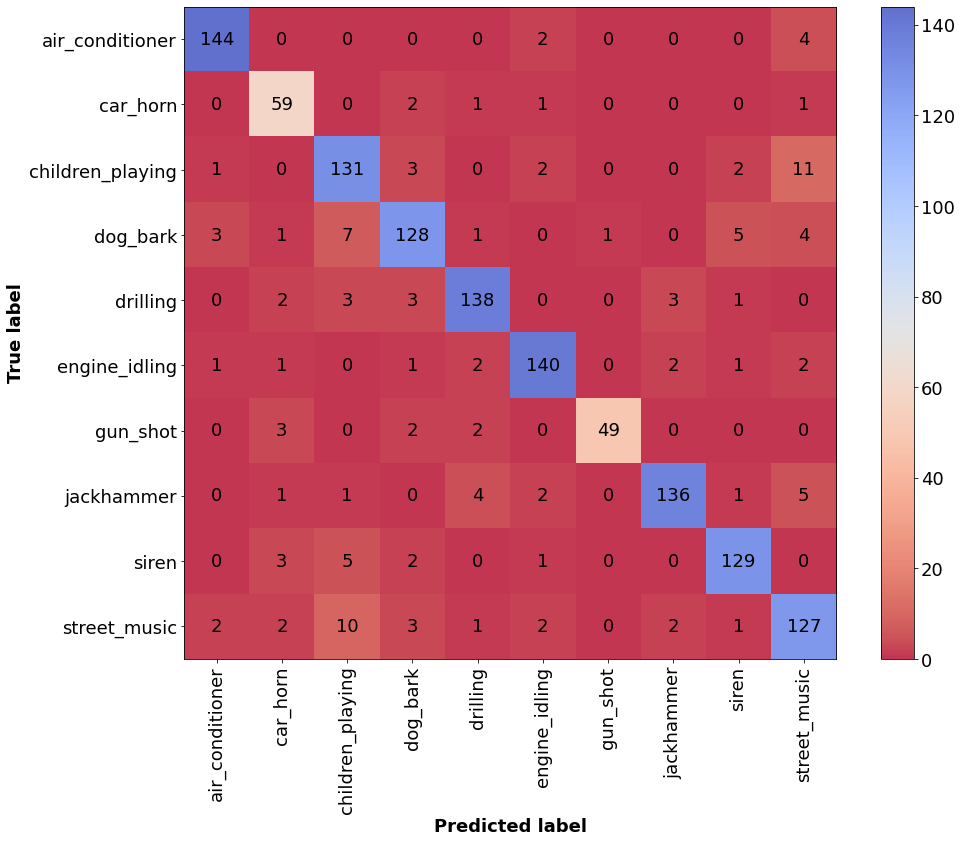

In [21]:
class_dictionary = {3: 'dog_bark', 2: 'children_playing', 1: 'car_horn', 0: 'air_conditioner', 9: 'street_music', 6: 'gun_shot', 8: 'siren', 5: 'engine_idling', 7: 'jackhammer', 4: 'drilling'}
classes = [class_dictionary[key] for key in sorted(class_dictionary.keys())]

plot_confusion_matrix(matrix, classes)

## Conclusions

Мы можем наблюдать увеличение точности набора тестов на 1-2% при введении отсева в качестве регуляризации. Это показывает, что это было успешное дополнение к нашей модели.

Есть много вещей, которые мы можем попробовать улучшить производительность модели, например:

- Настройка гиперпараметров:
   - Настройка параметров извлечения признаков
   - Настройка параметров сети (количество слоев, объединение слоев, количество и форма фильтра...)
   - Настройка гиперпараметров сети (скорость обучения, оптимизатор)

- Извлечение признаков:
   - Используйте STFT: необработанная спектрограмма может предоставить CNN больше информации для изучения корреляции между частотой и временем, чем MFCC.
   - Используйте мел-спектограмму: Мел-спектограмма может предоставить CNN больше информации для изучения корреляции между частотой и временем, чем MFCC.